<a href="https://colab.research.google.com/github/qaixerabbas/steel_defect_detection/blob/master/Steel_Defect_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd /content/drive/'My Drive'/Steel Defect Classification

/content/drive/My Drive/Steel Defect Classification


In [0]:
!ls

 data_steel  'Steel Defect Classification.ipynb'


In [0]:
#Importing suppourtive libraries for this task
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split

In [0]:
#for image manipulation
import cv2
import glob
import numpy as np

In [0]:
#Pytorch, FastAI & Matplotlib
import torch 
import torchvision
from fastai.callbacks import *
from fastai.vision import *
from fastai.metrics import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
bs = 32  #batch size
sz = 224 #image dimentions
PATH = './data_steel'

In [0]:
classes = []
for d in os.listdir(PATH):
    if os.path.isdir(os.path.join(PATH, d)) and not d.startswith('.'):
        classes.append(d) 
print ("There are ", len(classes), "classes:\n", classes) 

There are  6 classes:
 ['inclusion', 'scratches', 'rolledin', 'patches', 'crazing', 'pittedsurface']


In [0]:
for c in classes:
    print ("Class:", c)
    verify_images(os.path.join(PATH, c), delete=True);

Class: inclusion


Class: scratches


Class: rolledin


Class: patches


Class: crazing


Class: pittedsurface


In [0]:
data  = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=sz, bs=bs, valid_pct=0.3).normalize(imagenet_stats)

In [0]:
print ("Train Images: ", len(data.train_ds), " validation images: ", len(data.valid_ds) )

Train Images:  1643  validation images:  704


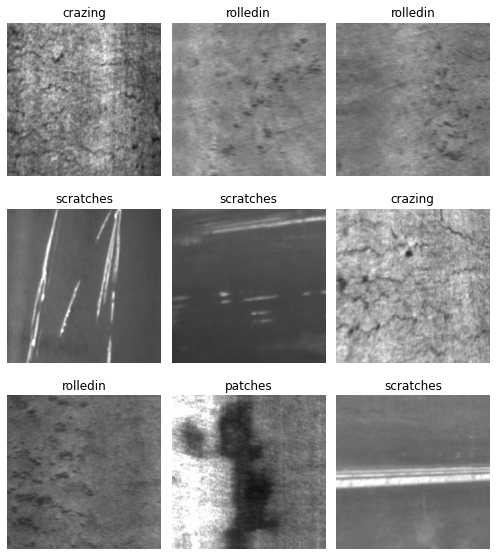

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


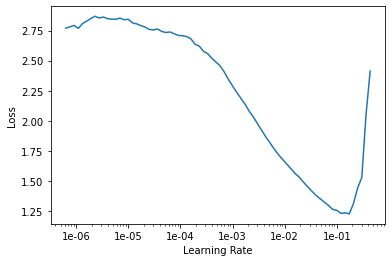

In [0]:
learn.lr_find();
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10, max_lr=slice(1e-02,1e-01))

epoch,train_loss,valid_loss,accuracy,time
0,0.303179,0.074429,0.975852,00:14
1,0.477060,9.534534,0.626420,00:14
2,1.802188,14.189505,0.687500,00:13
3,2.345788,0.606377,0.973011,00:13
4,1.421769,0.000000,1.000000,00:13
5,1.030158,0.072633,0.995739,00:13
6,0.664198,0.083426,0.991477,00:13
7,0.329676,0.223453,0.994318,00:13
8,0.149892,0.031432,0.995739,00:13
9,0.099729,0.004533,0.997159,00:13


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

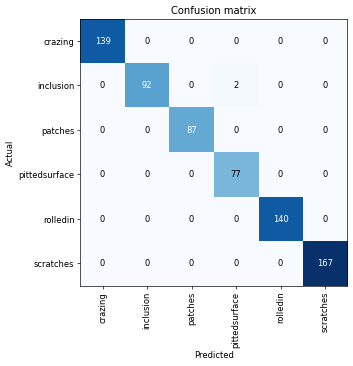

In [0]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60)


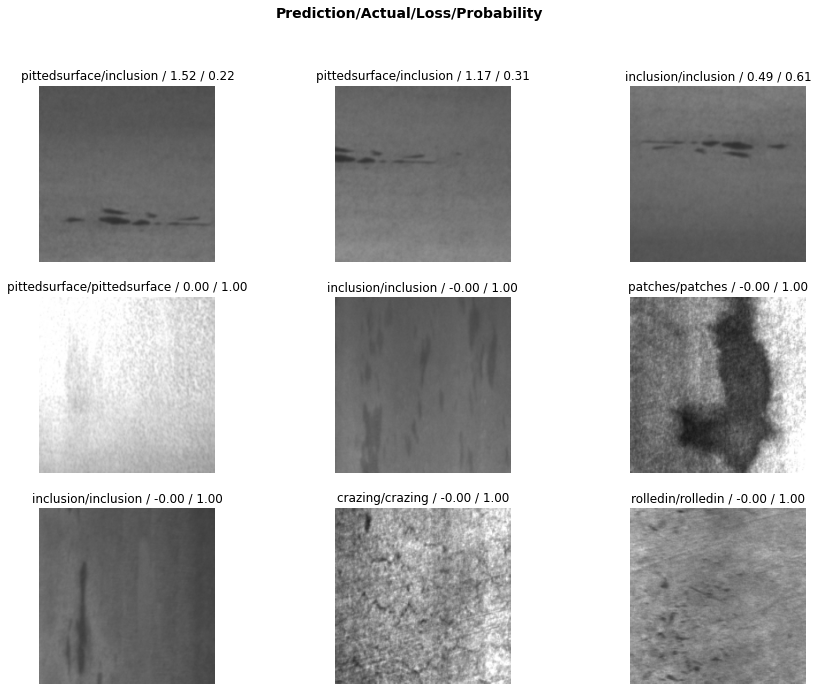

In [0]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

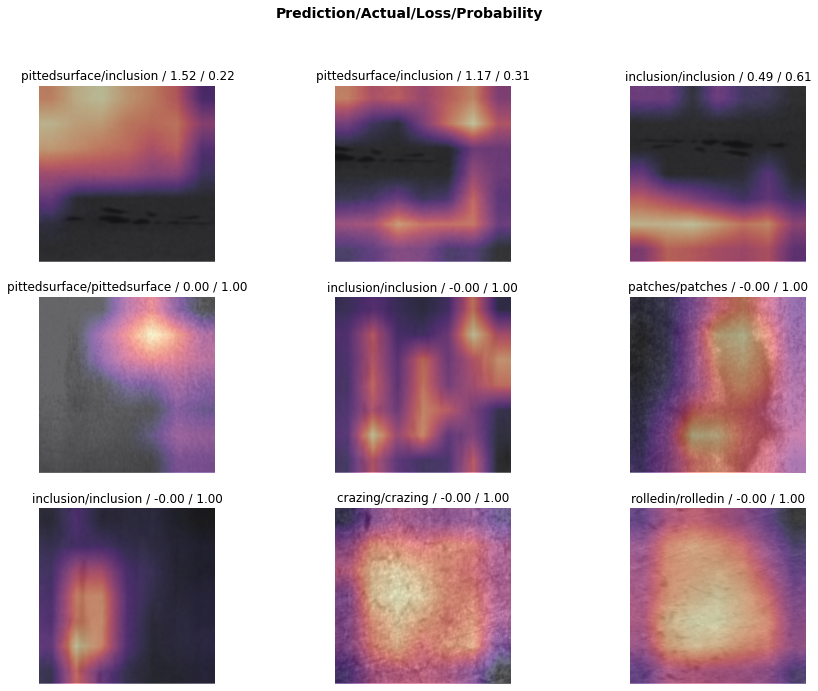

In [0]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)

In [0]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix()
conf=interp.confusion_matrix()
TrueNagitive=conf[0][0]
FalseNegative=conf[0][1]
TruePositive=conf[1][1]
FalsePositive=conf[1][0]
recal=TruePositive/(TruePositive+FalseNegative)
precision=TruePositive/(TruePositive+FalsePositive)
print("Precision: ",precision,"Recall:  ", recal)
f1=2*((precision*recal)/(precision+recal))
print('F1 Score:  =',f1)

Precision:  1.0 Recall:   1.0
F1 Score:  = 1.0


In [0]:
from sklearn import metrics
preds,y, loss = learn.get_preds(with_loss=True)

In [0]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 1.0


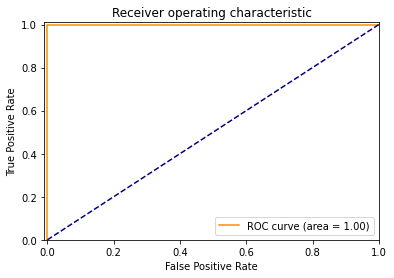

In [0]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")